<a href="https://colab.research.google.com/github/Hayrelen/kuzushiji-recognition/blob/main/Kuzushiji_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
import cv2
import math

import numpy as np # linear algebra|
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import os
import PIL
from scipy.ndimage import gaussian_filter

from tqdm.notebook import tqdm
from tensorflow import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow import convert_to_tensor
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

os.listdir("../content")

['.config', 'drive', 'sample_data']

## TPU setup

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.5.0
Running on TPU  ['10.117.245.82:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.117.245.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.117.245.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Download Kaggle dataset

In [ ]:
! pip install kaggle --upgrade #--force-reinstall --no-deps kaggle
from google.colab import files
files.upload()

In [6]:
import time
start = time.time()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list


ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              229KB  2021-05-21 06:23:33           5958  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           3334  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1174  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1919  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [7]:
! kaggle competitions download --force -c 'kuzushiji-recognition'
! mkdir train_images
! unzip kuzushiji-recognition.zip
! unzip -q train_images.zip -d train_images

! unzip train.csv.zip

  0% 0.00/73.8k [00:00<?, ?B/s]
100% 73.8k/73.8k [00:00<00:00, 27.8MB/s]
100% 1.38G/1.38G [00:18<00:00, 60.5MB/s]

100% 5.84M/5.84M [00:00<00:00, 57.1MB/s]

  0% 0.00/51.4k [00:00<?, ?B/s]
100% 51.4k/51.4k [00:00<00:00, 29.9MB/s]
100% 2.80G/2.81G [00:53<00:00, 70.4MB/s]
100% 2.81G/2.81G [00:53<00:00, 56.7MB/s]
unzip:  cannot find or open kuzushiji-recognition.zip, kuzushiji-recognition.zip.zip or kuzushiji-recognition.zip.ZIP.
Archive:  train.csv.zip
  inflating: train.csv               


In [8]:
import matplotlib as mpl
mpl.rc('image', cmap='viridis')

## Geting the test/train dataframes

In [9]:
train = pd.read_csv('../content/train.csv')
train.dropna(inplace=True)
train.reset_index(inplace=True)
train_len = len(train)
unicode_translation = pd.read_csv('../content/unicode_translation.csv')

In [ ]:
train.head()

,index,image_id,labels
0,0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


## Label encoding

In [ ]:
all_labels = []
for i in tqdm(train.index):
    all_labels = all_labels + train.labels[i].split()[::5]

all_labels.append('PAD')

le = LabelEncoder()
le.fit(all_labels)
vocabulary_size = len(le.classes_)
ENCODER = le
le.transform(['U+306F'])
vocabulary_size

# 'Document' and 'Glyph' classes

In [5]:
class Glyph:

    def __init__(self, 
                 unicode=None, 
                 x_corn=None, 
                 y_corn=None, 
                 width=None, 
                 height=None):
        
        self.unicode = unicode
        self.x_corn = int(x_corn)
        self.y_corn = int(y_corn)
        self.width = int(width)
        self.height = int(height)
        # self.dimenions = np.array([int(width), int(height)])
        self.dimenions = np.clip(np.array([int(width), int(height)]), 1, None)
        x = self.x_corn + self.width//2
        y = self.y_corn + self.height//2
        self.coordinates = np.array([x, y])

    def __float__(self):
        return self.coordinates

In [ ]:
class Document:

    def __init__(self, dataframe_row=None, image_path=None, labels_as_string=None, final_size=512):

        image_path = '../content/train_images/' + train.iloc[dataframe_row].image_id + '.jpg'
        self.image = cv2.imread(image_path,0).T #.transpose([1,0,2])
        self.__ratios = 512/np.array(self.image.shape)
        self.image = cv2.resize(self.image, (final_size, final_size))
        self.labels = []
        labels_as_string = train.iloc[dataframe_row].labels
        self.len = len(labels_as_string.split())//5
        for i in range(0,len(labels_as_string.split()),5):
            glyph = Glyph(*labels_as_string.split()[i:i+5])
            glyph.coordinates = (glyph.coordinates*self.__ratios).astype(int)
            glyph.dimenions = (glyph.dimenions*self.__ratios).astype(int)
            self.labels.append(glyph)

    def get_glyphs_coordinates(self):
        return np.array([glyph.coordinates for glyph in self.labels])

    def show_image(self):
        plt.imshow(self.image.T)

    def get_glyphs_map(self, map_size=512):
        map = np.zeros((512,512,vocabulary_size), dtype=np.float16)
        for glyph in self.labels:
            point_map = np.zeros(tuple(np.clip(glyph.dimenions, 1, None)))
            point_coordinates = glyph.dimenions//2
            point_map[tuple(point_coordinates)] = 1
            point_map = gaussian_filter(point_map, glyph.dimenions/6)
            point_map = point_map/point_map.max()
            box_l = glyph.coordinates - glyph.dimenions//2
            box_l = np.clip(box_l, 0, 512)
            box_r = box_l + glyph.dimenions
            box_r = np.clip(box_r, 0, 512)
            final_glyph_dimentions = map[box_l[0]:box_r[0],box_l[1]:box_r[1]].shape
            map[box_l[0]:box_r[0], box_l[1]:box_r[1], le.transform([glyph.unicode])[0]] += point_map[:final_glyph_dimentions[0],:final_glyph_dimentions[1]]
        return map

# Pipeline

In [ ]:
def get_predictions(doc):
    glyphs_locations = detect_glyphs(doc.image, object_detection_model)
    # use skimage.feature.peak_local_max?
    for location in glyph_locations:
        doc.labels.append(Glyph(coordinates = location))
    doc.sort_labels()
    classify_glyphs(doc, classification_model)
    decode_predictions(doc, language_model)
    

# Object Detection

## Creating training set for future loading

In [14]:
X = np.zeros((3605,512,512,1),dtype='float16')
y = np.zeros_like(X, dtype='float16')

In [ ]:
with open('X.npy', 'wb') as f:
    np.save(f, X)
with open('y.npy', 'wb') as f:
    np.save(f, y)

## Creating tensorflow dataset

In [3]:
X = np.load('../content/drive/MyDrive/X.npy')
y = np.load('../content/drive/MyDrive/y.npy')
X.shape

(3605, 512, 512, 1)

In [4]:
X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)

In [5]:
BATCH_SIZE = 8 * tpu_strategy.num_replicas_in_sync

train_dataset = tf.data.Dataset.from_tensor_slices((X[:3000],y[:3000]))
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X[3000:],y[3000:]))
val_dataset = val_dataset.batch(BATCH_SIZE)

print(BATCH_SIZE)

64


## Model

### Focal Loss

https://github.com/aldi-dimara/keras-focal-loss/blob/master/focal_loss.py

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 19 08:20:58 2018
@OS: Ubuntu 18.04
@IDE: Spyder3
@author: Aldi Faizal Dimara (Steam ID: phenomos)
"""

import keras.backend as K
import tensorflow as tf

def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha_t*((1-p_t)^gamma)*log(p_t)
        
        p_t = y_pred, if y_true = 1
        p_t = 1-y_pred, otherwise
        
        alpha_t = alpha, if y_true=1
        alpha_t = 1-alpha, otherwise
        
        cross_entropy = -log(p_t)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true)*alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1-p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss    

### Actual Keras model

I took the model from official Keras object detection examples, changing the activation function on the output layer from `'softmax'` to `'sigmoid'` since we are solving a regression problem.

In [12]:
# https://keras.io/examples/vision/oxford_pets_image_segmentation/

from tensorflow.keras import layers
from tensorflow import keras


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    # model.compile(optimizer="rmsprop", loss=binary_focal_loss(alpha=.25, gamma=2))
    # model.compile(optimizer="rmsprop", loss=tf.keras.losses.Huber())
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss=binary_focal_loss(alpha=.25, gamma=2),
        )
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
with tpu_strategy.scope():
    model = get_model((512,512), 1)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Fitting and results

In [ ]:
# history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)
# model.save('../content/drive/MyDrive/model.h5')
# plt.plot(history.history['val_loss'])

In [11]:
with tpu_strategy.scope():
    model = keras.models.load_model('../content/drive/MyDrive/model.h5')

### Testing

In [13]:
preds = model.predict(val_dataset, verbose=1)

10/10 [==============================] - 16s 2s/step


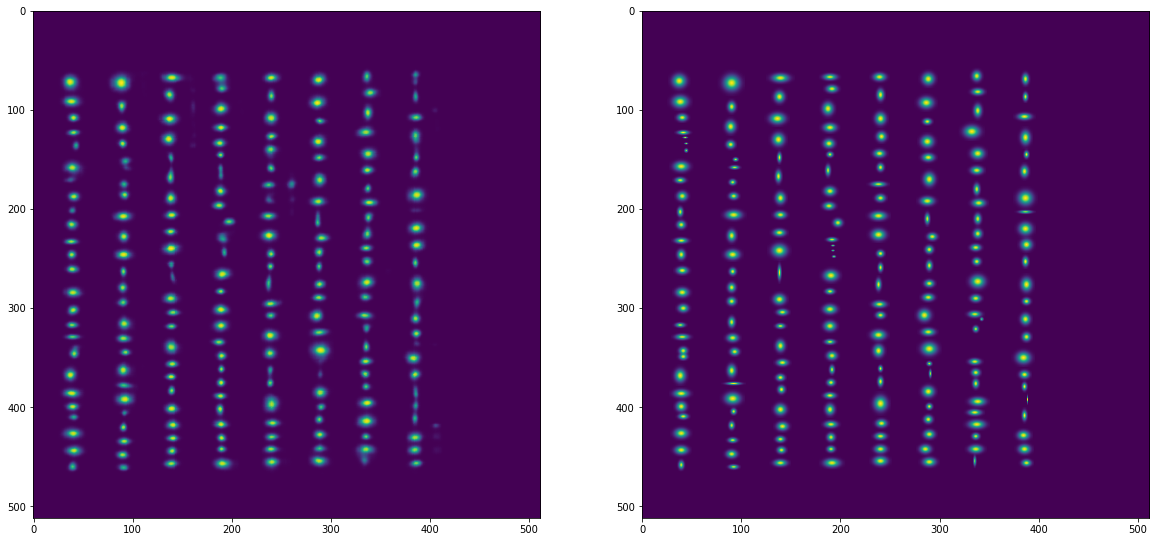

In [14]:
i = 1

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(preds[i].reshape((512,512)).T)
plt.subplot(1,2,2)
plt.imshow(y[3000+i].numpy().reshape((512,512)).astype('float32').T)

Looks good. Now we just need to find local maxima of the heatmap.

# Classification

# Language Model

# Beam Search Decoding